In [19]:
# Imports
# Gymnasium imports
import gymnasium as gym 
from gymnasium import Env
from gymnasium.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete 

import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

# Import helpers
import numpy as np
import pandas as pd
import random
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns

from collections import deque

# Import stable baselines
from stable_baselines3 import PPO, A2C, DDPG
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv, VecNormalize
from stable_baselines3.common.env_util import make_vec_env, SubprocVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.noise import NormalActionNoise

# Import tensorflow
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import TensorBoard

# Import custom classes
from Environment.env_v9 import *
from Functions.visualization_functions import *

In [20]:
# Configuration of the network
with open('./Config/network_config_v1.json') as file:
    network_config = file.read()

EP_LENGTH = 100 # Length of the episode

In [21]:
def load_config(config_file):

    with open(config_file, "r") as f:
        config = json.load(f)
    return config

def make_env(config_file="config.json"):

    config = load_config(config_file)

    env = SS_Mngmt_Env(
        network_config=network_config,
        EP_LENGTH=EP_LENGTH,
        render_mode="human",
        model_type="DDPG",
        stockout_cost=config["stockout_cost"],
        order_cost=config["order_cost"],
        item_cost=config["item_cost"],
        stock_cost=config["stock_cost"],
        item_prize=config["item_prize"],
        progressive_stock_cost=config["progressive_stock_cost"],
        stock_out_max=config["stock_out_max"],
        order_quantities=config["order_quantities"],
        demand_mean=config["demand_mean"],
        demand_std=config["demand_std"],
        demand_noise=config["demand_noise"],
        demand_noise_std=config["demand_noise_std"],
        demand_prob=config["demand_prob"],
        extreme=True,
        seasonality=True,
    )

    # Wrap the environment with the monitor and for box actions
    return Monitor(MultiDiscreteToBoxWrapper(env))

env = make_env("./Config/env_config_v0.json")
check_env(env, warn=True)

/Users/jonasrenfer/miniconda3/envs/rl-scm/lib/python3.12/site-packages/stable_baselines3/common/env_checker.py:263: UserWarning: Your observation order_queues has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(
/Users/jonasrenfer/miniconda3/envs/rl-scm/lib/python3.12/site-packages/stable_baselines3/common/env_checker.py:453: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


In [22]:
vec_env = DummyVecEnv([lambda: make_env("./Config/env_config_v0.json")])
vec_env = VecNormalize(vec_env, norm_obs=True, norm_reward=True, clip_obs=10.0)

model_path = os.path.join('Training', 'Models', 'DDPG')
log_path = os.path.join('Training', 'Logs', 'DDPG')

In [23]:
# # Add noise for exploration in continuous action space
# n_actions = vec_env.action_space.shape[0]
# action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

# Train the DDPG agent
model = DDPG(
    "MultiInputPolicy", 
    vec_env,
    verbose=0, 
    learning_rate=1e-3, 
    buffer_size=1_000_000, 
    batch_size=256, 
    tau=0.005, 
    gamma=0.99, 
    train_freq=(1, "episode"),
    action_noise=None,
    gradient_steps=1,
    learning_starts=100,
    tensorboard_log=log_path,
)

# Train the model
model.learn(total_timesteps=500_000)

In [24]:
model.save(os.path.join(model_path, "DDPG_SS_Mngmt_v0"))

In [37]:
evaluate_policy(model, vec_env, n_eval_episodes=10, render=False, return_episode_rewards=True)

([-148107.34,
  -166059.16,
  -107392.67,
  -60578.75,
  -180626.43,
  -53330.93,
  -115837.94,
  -32698.87,
  -152981.67,
  -156335.18],
 [98, 100, 71, 2, 100, 6, 74, 25, 100, 100])

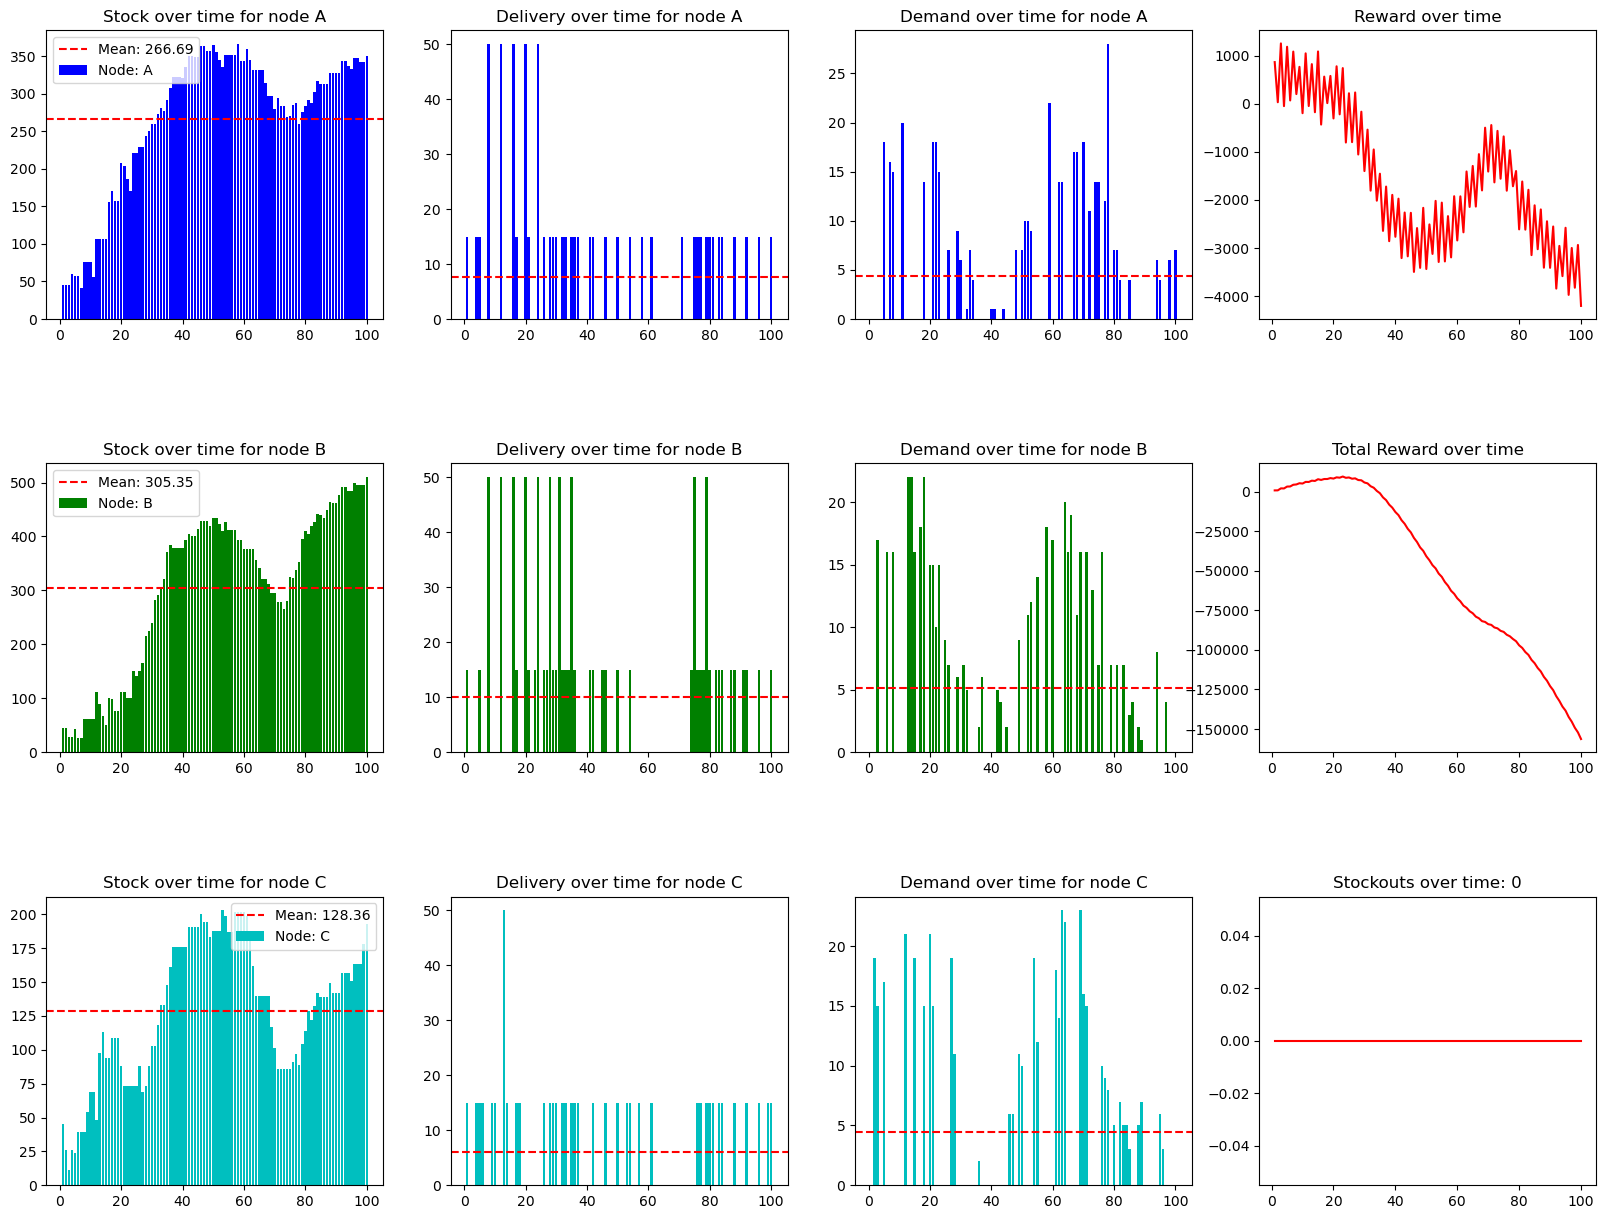

In [38]:
file = './Data/2024-12-04_environment_data_DDPG.csv'
df = pd.read_csv(file)

plot_data(df)